In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, MaxPooling1D, GlobalMaxPooling1D,Bidirectional
from keras.layers.convolutional import Conv1D
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
import json
file = open("data_file_2L.json", 'r')
json_data = json.load(file)
merged_dict = {}
for dictionary in json_data:
    for key, value in dictionary.items():
        if key not in merged_dict:
            merged_dict[key] = []
        merged_dict[key].append(value)
file.close()
print(merged_dict.keys())

dict_keys(['date', 'prefix', 'fullName', 'firstName', 'lastName', 'ssn', 'contactNo.', 'email', 'gender', 'streetAddress', 'zipCode', 'city', 'state', 'country'])


In [ ]:
# Print predicted labels and confidence scores
def output_pred(x,y):
    for label, score in zip(x, y):
        if label == 0:
            print("The model predicts the input text to be --->Date")
        elif label == 1:
            print("The model predicts the input text to be --->Prefix")
        elif label == 2:
            print("The model predicts the input text to be --->fullName")
        elif label == 3:
            print("The model predicts the input text to be --->firstName")
        elif label == 4:
            print("The model predicts the input text to be --->lastName")
        elif label == 5:
            print("The model predicts the input text to be --->SNN")
        elif label == 6:
            print("The model predicts the input text to be --->ContactNumber")
        elif label == 7:
            print("The model predicts the input text to be --->Email-ID")
        elif label == 8:
            print("The model predicts the input text to be --->Gender")
        elif label == 9:
            print("The model predicts the input text to be --->streetAddress")
        elif label == 10:
            print("The model predicts the input text to be --->zipCode")
        elif label == 11:
            print("The model predicts the input text to be --->City")
        elif label == 12:
            print("The model predicts the input text to be --->State")
        elif label == 13:
            print("The model predicts the input text to be --->Country")
        print("with a confidence score of:", score)

In [ ]:
# data
texts = [value for values in merged_dict.values() for value in values]

# labels
lengths_list = [len(values) for values in merged_dict.values()]
all_labels=[]
for i in range(0,len(lengths_list)):
    all_labels += [i] * lengths_list[i]

In [ ]:
# Tokenizing the texts
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [ ]:
# Pading the sequences
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [ ]:
# Converting the labels to one-hot encoding
num_classes = len(np.unique(all_labels))
one_hot_labels = to_categorical(all_labels, num_classes=num_classes)

In [ ]:
# Calculate the number of data points per label
num_labels = one_hot_labels.shape[1]
num_points_per_label = np.sum(one_hot_labels, axis=0)

# Calculate the number of data points for each set
total_size = np.sum(num_points_per_label)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

# Create empty arrays to hold the indices for each set
train_indices = []
val_indices = []
test_indices = []

# Loop through each label and divide the indices into the sets
for label in range(num_labels):
    # Get the indices for the current label
    label_indices = np.where(one_hot_labels[:, label] == 1)[0]

    # Shuffle the indices
    np.random.shuffle(label_indices)

    # Divide the indices into the sets
    num_train_points = int(num_points_per_label[label] * 0.6)
    num_val_points = int(num_points_per_label[label] * 0.2)
    num_test_points = num_points_per_label[label] - num_train_points - num_val_points

    train_indices.extend(label_indices[:num_train_points])
    val_indices.extend(label_indices[num_train_points:num_train_points+num_val_points])
    test_indices.extend(label_indices[num_train_points+num_val_points:num_train_points+num_val_points+int(num_test_points)])

# Use the indices to extract the sequences and labels for each set
train_sequences = padded_sequences[np.array(train_indices)]
train_labels = one_hot_labels[np.array(train_indices)]
val_sequences = padded_sequences[np.array(val_indices)]
val_labels = one_hot_labels[np.array(val_indices)]
test_sequences = padded_sequences[np.array(test_indices)]
test_labels = one_hot_labels[np.array(test_indices)]

In [ ]:
# Calculating the class weights
class_weights = dict(zip(np.unique(all_labels), compute_class_weight(class_weight = "balanced", classes = np.unique(all_labels), y = all_labels)))

**MODEL**

In [ ]:
# Set hyperparameters
epochs=100
batchsize=64
embedding_dim = 100
num_filters = 64
filter_size = 5
lstm_units = 64
dropout_rate = 0.5

In [ ]:
# Define the model architecture
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim, input_length=max_sequence_length))

# Convolutional layer
model.add(Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Dropout layer
model.add(Dropout(dropout_rate))

In [ ]:
# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate)))

# Dense output layer
model.add(Dense(units = num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 41, 100)           5000      
                                                                 
 conv1d (Conv1D)             (None, 37, 64)            32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 18, 64)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 14)                1

In [ ]:
# Training the model
if len(class_weights) > 0:
    history = model.fit(train_sequences, train_labels, validation_data = (val_sequences,val_labels), epochs=100, batch_size=64, class_weight=class_weights)
else:
    history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=100, batch_size=64)

Epoch 1/100
23078/23078 [==============================] - 842s 36ms/step - loss: 0.2337 - accuracy: 0.9050 - val_loss: 0.1452 - val_accuracy: 0.9416
Epoch 2/100
23078/23078 [==============================] - 747s 32ms/step - loss: 0.1702 - accuracy: 0.9304 - val_loss: 0.1357 - val_accuracy: 0.9443
Epoch 3/100
23078/23078 [==============================] - 750s 33ms/step - loss: 0.1605 - accuracy: 0.9344 - val_loss: 0.1271 - val_accuracy: 0.9492
Epoch 4/100
23078/23078 [==============================] - 751s 33ms/step - loss: 0.1553 - accuracy: 0.9364 - val_loss: 0.1248 - val_accuracy: 0.9493
Epoch 5/100
23078/23078 [==============================] - 749s 32ms/step - loss: 0.1517 - accuracy: 0.9379 - val_loss: 0.1205 - val_accuracy: 0.9498
Epoch 6/100
23078/23078 [==============================] - 747s 32ms/step - loss: 0.1497 - accuracy: 0.9385 - val_loss: 0.1191 - val_accuracy: 0.9513
Epoch 7/100
23078/23078 [==============================] - 753s 33ms/step - loss: 0.1478 - accuracy:

23078/23078 [==============================] - 733s 32ms/step - loss: 0.1471 - accuracy: 0.9416 - val_loss: 0.1684 - val_accuracy: 0.9413
Epoch 56/100
23078/23078 [==============================] - 735s 32ms/step - loss: 0.1441 - accuracy: 0.9426 - val_loss: 0.1790 - val_accuracy: 0.9416
Epoch 57/100
23078/23078 [==============================] - 732s 32ms/step - loss: 0.1442 - accuracy: 0.9427 - val_loss: 0.1799 - val_accuracy: 0.9404
Epoch 58/100
23078/23078 [==============================] - 736s 32ms/step - loss: 0.1448 - accuracy: 0.9426 - val_loss: 0.1297 - val_accuracy: 0.9532
Epoch 59/100
23078/23078 [==============================] - 742s 32ms/step - loss: 0.1439 - accuracy: 0.9425 - val_loss: 0.1918 - val_accuracy: 0.9402
Epoch 60/100
23078/23078 [==============================] - 735s 32ms/step - loss: 0.1446 - accuracy: 0.9426 - val_loss: 0.2610 - val_accuracy: 0.9170
Epoch 61/100
23078/23078 [==============================] - 738s 32ms/step - loss: 0.1444 - accuracy: 0.942

In [ ]:
# Save Model and Weights
model.save('CNN+BiLSTM.h5')
model.save_weights('CNN+BiLSTM.hdf5')

In [ ]:
# Load saved model
model = models.load_model('CNN+BiLSTM.h5')

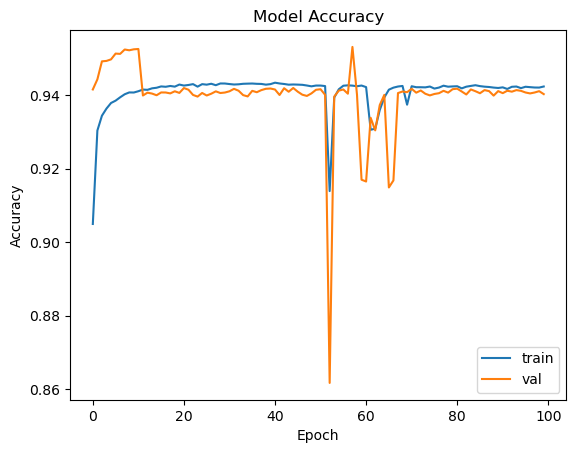

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

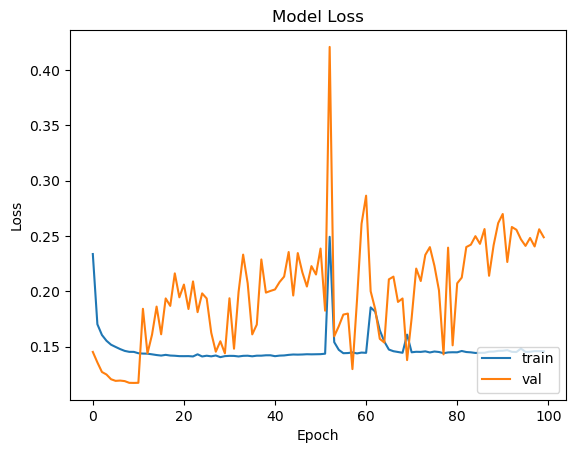

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
# Evaluating the model on the test set
loss, accuracy = model.evaluate(test_sequences, test_labels)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

15386/15386 [==============================] - 68s 4ms/step - loss: 0.2458 - accuracy: 0.9412
Test loss: 0.24580708146095276
Test accuracy: 0.9412132501602173


In [ ]:
y_pred = model.predict(test_sequences, batch_size=batchsize)

7693/7693 [==============================] - 41s 5ms/step


In [ ]:
predicted_labels = np.argmax(y_pred, axis=1)

In [ ]:
actual_labels = np.argmax(test_labels, axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# Get the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Print the classification report
print(classification_report(actual_labels, predicted_labels))

# Print the confusion matrix
print("Confusion Matrix:")
print(np.array2string(cm, separator=', '))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40000
           1       0.98      0.83      0.90     37594
           2       0.97      1.00      0.99     33883
           3       0.71      0.78      0.74     33883
           4       0.74      0.70      0.72     33883
           5       1.00      1.00      1.00     29850
           6       1.00      1.00      1.00     27831
           7       1.00      1.00      1.00     37873
           8       1.00      1.00      1.00     40000
           9       1.00      1.00      1.00     21226
          10       1.00      1.00      1.00     38715
          11       0.96      0.94      0.95     38719
          12       0.85      0.97      0.91     39743
          13       1.00      0.97      0.98     39122

    accuracy                           0.94    492322
   macro avg       0.94      0.94      0.94    492322
weighted avg       0.94      0.94      0.94    492322

Confusion Matrix:
[[40000

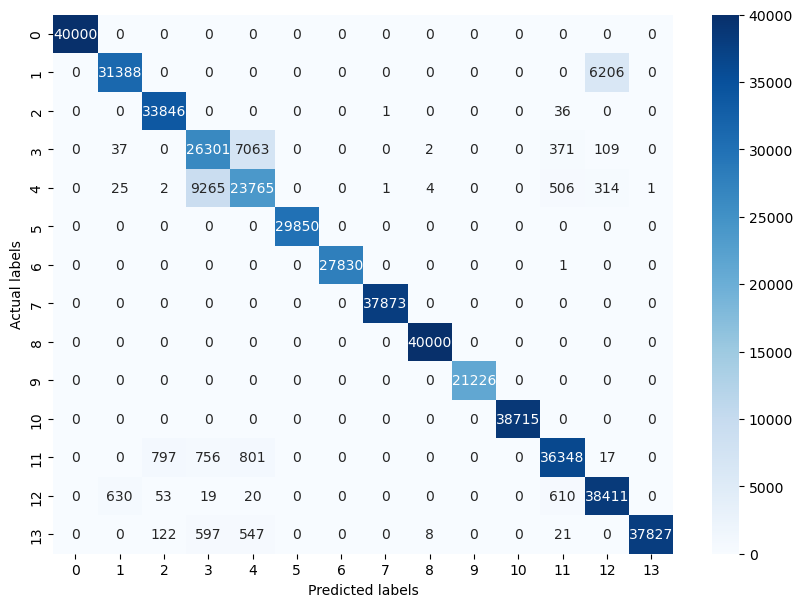

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.show()

In [ ]:
import xlsxwriter

# dictionary mapping labels to their respective text values
label2text = {0: "Date", 1: "Name Prefix", 2: "fullName", 3: "firstName", 4: "lastName", 5: "SNN", 6: "Contact Number", 7: "Email-ID", 8: "Gender", 9: "streetAddress", 10: "zipCode", 11: "City", 12: "State", 13: "Country"}

# Convert numeric class labels to text labels
expected_texts = [label2text[label] for label in actual_labels]
predicted_texts = [label2text[label] for label in predicted_labels]

# Create a new Excel workbook and add a worksheet
workbook = xlsxwriter.Workbook('CNN+Bi-LSTMPredictions.xlsx')
worksheet = workbook.add_worksheet()

# Add headers to the worksheet
worksheet.write('A1', 'Input Text')
worksheet.write('B1', 'Expected')
worksheet.write('C1', 'Predicted')

# Write the input text, expected, and predicted values to the worksheet
for i in range(len(test_sequences)):
    input_text = tokenizer.sequences_to_texts([test_sequences[i]])[0]
    expected_value = expected_texts[i]
    predicted_value = predicted_texts[i]
    worksheet.write(i+1, 0, input_text)
    worksheet.write(i+1, 1, expected_value)
    worksheet.write(i+1, 2, predicted_value)

# Close the workbook
workbook.close()

In [ ]:
# Testcase
# Tokenize new texts
new_texts = ["bharath"]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)

# Make predictions on new texts and calculate confidence scores
predictions = model.predict(new_padded_sequences)
predicted_labels = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)
output_pred(predicted_labels,confidence_scores)

1/1 [==============================] - 0s 19ms/step
The model predicts the input text to be --->lastName
with a confidence score of: 0.78185576
